<a href="https://colab.research.google.com/github/EzpieCo/pytorch-crash-course-official/blob/main/05_PyTorch_Multi_classificaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 Non-linearity

GitHub repository: https://github.com/ezpie1/PyTorch-Crash-Course

Crash Course: https://ezpie.vercel.app/courses/machine-learning

In case of an question: https://github.com/ezpie1/PyTorch-Crash-Course/discussions

## Chapter: Creating dataset for multi-classification

Now we will create a dataset for multi-classification.

The dataset would have 5 different values - red, yellow, blue, lightblue, orange

In [250]:
#@title Importing dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [251]:
#@title Create data of 5 classes(5 different values)
X, y = make_blobs(n_samples=1000,
                            n_features=2,
                            centers=5,
                            cluster_std=1.5,
                            random_state=23)

print(f'X First 5: {X[:5]} \n y first 5: {y[:5]}')

X First 5: [[ 4.98793697 -5.12231314]
 [-5.18612453  4.38348826]
 [-0.47572433  7.92012467]
 [-4.56951741 -2.48790966]
 [-8.48679297  3.10505914]] 
 y first 5: [1 2 0 3 2]


In [252]:
#@title convert data from numpy to pytorch float data type

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

print(f'X first 5: {X[:5]} \n y first 5: {y[:5]}')

X first 5: tensor([[ 4.9879, -5.1223],
        [-5.1861,  4.3835],
        [-0.4757,  7.9201],
        [-4.5695, -2.4879],
        [-8.4868,  3.1051]]) 
 y first 5: tensor([1, 2, 0, 3, 2])


In [253]:
#@title viewing first 10 values

import pandas as pd

data_frame = pd.DataFrame({"X1": X[:, 0],
                           "X2": X[:, 1],
                           "label": y})

data_frame.head(10)

,X1,X2,label
0,4.987937,-5.122313,1
1,-5.186124,4.383488,2
2,-0.475724,7.920125,0
3,-4.569518,-2.487910,3
4,-8.486793,3.105059,2
5,2.758896,-3.981983,4
6,-7.009574,-3.746344,3
7,-8.353763,5.716077,2
8,-0.699542,0.236560,4
9,5.176438,-2.204833,1


In [254]:
#@title splitting data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

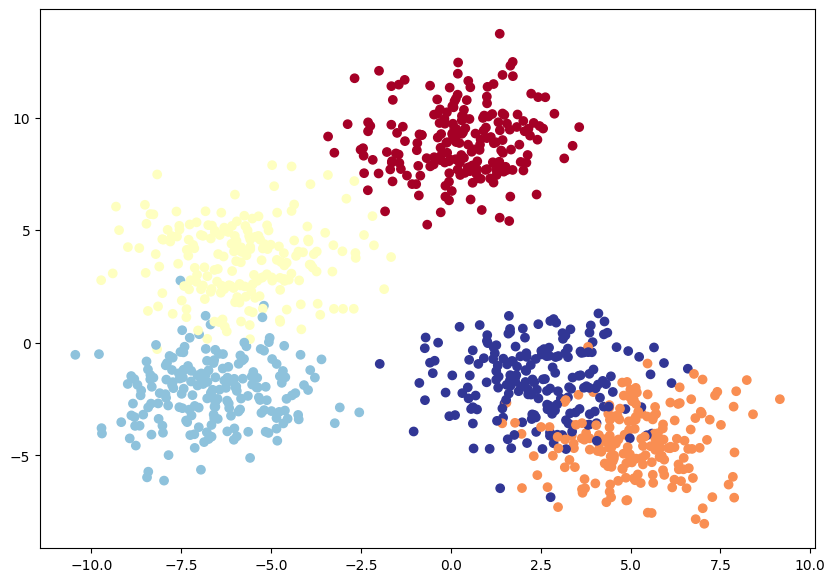

In [255]:
#@title visualizing the dataset

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [256]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Chapter: Creating model for multi-classification

In this chapter we will create a model and training loop.

But our main quest is, should it be linear or non-linear?

In [257]:
# Linear model
class ModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(2, 10)
    self.layer2 = nn.Linear(10, 10)
    self.layer3 = nn.Linear(10, 5)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

# Create instance
model1 = ModelV1().to(device)
model1

ModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=5, bias=True)
)

In [258]:
# Non-linear model
class ModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(2, 8)
    self.layer2 = nn.Linear(8, 16)
    self.layer4 = nn.Linear(16, 5)

    self.relu = nn.ReLU()

  def forward(self, x):
    return self.relu(self.layer2(self.relu(self.layer1(x))))

# Create instance
model2 = ModelV2().to(device)
model2

ModelV2(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=5, bias=True)
  (relu): ReLU()
)

In [259]:
# Loss function
lossFn = nn.CrossEntropyLoss()

# For model1
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

# For model2
optimizer2 = torch.optim.SGD(params=model2.parameters(), lr=0.1)

### Understanding the softmax

Like in binary classification we used sigmoid activation function to convert our raw logits into prediction probabilities, in multi-classification we can't use
sigmoid, because it places a number between 0 and 1, but our dataset has 5 outcomes - red, yellow, blue, lightblue, orange.

In [260]:
#@title Getting raw logits

with torch.inference_mode():
  y_logits = model1(X_test)

y_logits[:1]

tensor([[ 0.4653,  1.6302,  0.4081, -0.1596, -0.0469]])

In [261]:
#@title converting logits into probabilities

y_probs = torch.softmax(y_logits, dim=1)

y_probs[:1]

tensor([[0.1591, 0.5101, 0.1503, 0.0852, 0.0953]])

In [262]:
#@title converting probabilities into labels

y_preds = y_probs.argmax(dim=1)

y_preds[:5]

tensor([1, 3, 0, 3, 1])

In [263]:
# accuracy function | Calculate how *good* the model is

def accuracy(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct/len(y_pred)) * 100
  return accuracy

In [264]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put train test into device agnostic
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Trainer for Linear model
def trainer(epochs=1000):
  # Train loop
  for epoch in range(epochs):
    model1.train()

    # Forward pass
    y_logit = model1(X_train)

    # Convert logits -> pred probs -> pred labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    # Calculate loss
    loss = lossFn(y_logit, y_train)
    acc = accuracy(y_pred, y_train)

    # gradient descend
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # optimizer step
    optimizer.step()

    # Test loop
    model1.eval()
    with torch.inference_mode():
      # Forward pass
      test_logit = model1(X_test)

      # Convert logits -> pred probs -> pred labels
      test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)

      # Calculate loss
      test_loss = lossFn(test_logit, y_test)
      test_acc = accuracy(test_pred, y_test)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train accuracy: {acc:.2f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")

# Trainer for non-linear model
def trainer2(epochs=1000):
  # Train loop
  for epoch in range(epochs):
    model2.train()

    # Forward pass
    y_logit = model2(X_train)

    # Convert logits -> pred probs -> pred labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    # Calculate loss
    loss = lossFn(y_logit, y_train)
    acc = accuracy(y_pred, y_train)

    # gradient descend
    optimizer2.zero_grad()

    # Backpropagation
    loss.backward()

    # optimizer step
    optimizer2.step()

    # Test loop
    model2.eval()
    with torch.inference_mode():
      # Forward pass
      test_logit = model2(X_test)

      # Convert logits -> pred probs -> pred labels
      test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)

      # Calculate loss
      test_loss = lossFn(test_logit, y_test)
      test_acc = accuracy(test_pred, y_test)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

In [265]:
trainer()

Epoch: 0 | Train loss: 2.31888 | Train accuracy: 0.62 | Test loss: 1.34170 | Test accuracy: 45.50
Epoch: 100 | Train loss: 0.22591 | Train accuracy: 92.50 | Test loss: 0.17964 | Test accuracy: 94.00
Epoch: 200 | Train loss: 0.18862 | Train accuracy: 92.25 | Test loss: 0.14965 | Test accuracy: 93.50
Epoch: 300 | Train loss: 0.16862 | Train accuracy: 93.50 | Test loss: 0.13524 | Test accuracy: 94.00
Epoch: 400 | Train loss: 0.15820 | Train accuracy: 93.62 | Test loss: 0.12809 | Test accuracy: 94.50
Epoch: 500 | Train loss: 0.15224 | Train accuracy: 93.88 | Test loss: 0.12374 | Test accuracy: 94.50
Epoch: 600 | Train loss: 0.14857 | Train accuracy: 94.25 | Test loss: 0.12079 | Test accuracy: 95.00
Epoch: 700 | Train loss: 0.14614 | Train accuracy: 94.25 | Test loss: 0.11862 | Test accuracy: 95.00
Epoch: 800 | Train loss: 0.14443 | Train accuracy: 94.50 | Test loss: 0.11694 | Test accuracy: 95.00
Epoch: 900 | Train loss: 0.14318 | Train accuracy: 94.50 | Test loss: 0.11559 | Test accuracy:

In [266]:
trainer2()

Epoch: 0 | Train loss: 3.41792 | Train accuracy: 0.00% | Test loss: 3.10749 | Test accuracy: 0.00%
Epoch: 100 | Train loss: 1.31619 | Train accuracy: 60.38% | Test loss: 1.31112 | Test accuracy: 59.00%
Epoch: 200 | Train loss: 1.28730 | Train accuracy: 60.50% | Test loss: 1.28615 | Test accuracy: 59.00%
Epoch: 300 | Train loss: 0.79143 | Train accuracy: 73.88% | Test loss: 0.88678 | Test accuracy: 70.50%
Epoch: 400 | Train loss: 0.73142 | Train accuracy: 75.62% | Test loss: 0.82119 | Test accuracy: 72.50%
Epoch: 500 | Train loss: 0.70449 | Train accuracy: 76.12% | Test loss: 0.79714 | Test accuracy: 72.00%
Epoch: 600 | Train loss: 0.68900 | Train accuracy: 76.38% | Test loss: 0.78510 | Test accuracy: 72.00%
Epoch: 700 | Train loss: 0.67934 | Train accuracy: 76.62% | Test loss: 0.77843 | Test accuracy: 71.50%
Epoch: 800 | Train loss: 0.67300 | Train accuracy: 76.75% | Test loss: 0.77433 | Test accuracy: 71.50%
Epoch: 900 | Train loss: 0.66867 | Train accuracy: 76.88% | Test loss: 0.7718

In [267]:
import numpy as np

def plot_decision_boundary(model, X, y):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
      y_logits = model(X_to_pred_on)

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

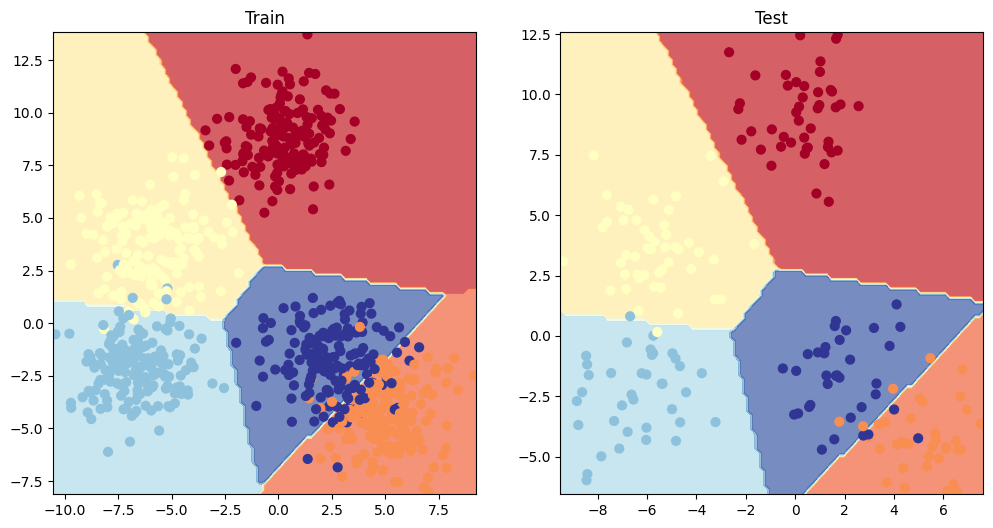

In [268]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

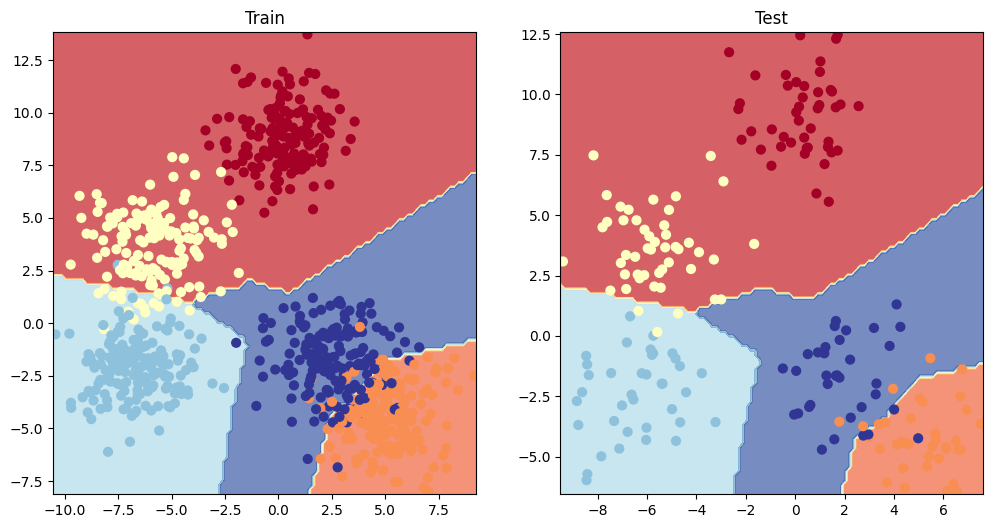

In [269]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)